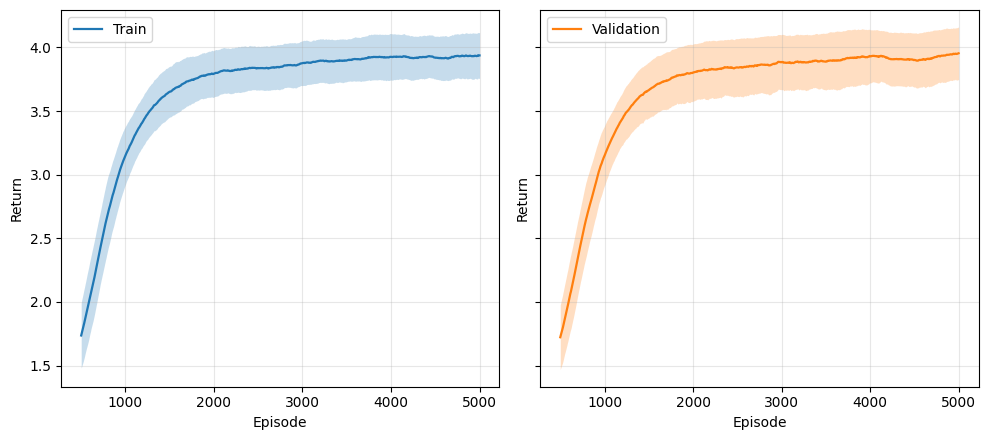

Figure saved → aggregated_ppo_side_by_side.png


In [5]:
"""
Figure 8 Plot: Aggregated PPO Performance (Train vs Validation)

This notebook visualizes the PPO agent’s learning performance across multiple random seeds.


- Loads per-seed training and validation reward logs
- Aggregates over common episode length
- Applies optional moving-average smoothing
- Plots side-by-side reward trends with 1σ confidence interval shading

To reproduce the manuscript's Figure 8 exactly, ensure NPZ logs are available under:
    ./train_logs/seed_*/results_train.npz
    ./eval_logs/seed_*/results_eval.npz
"""


import os
import numpy as np
import matplotlib.pyplot as plt

# ------------------- Moving-Average Smoother ----------------------------------
def moving_average(data: np.ndarray, window_size: int = 1) -> np.ndarray:
    """
    A simple moving average is applied to *data* with span *window_size*.
    If smoothing is not desired, set *window_size* ≤ 1.
    """
    if window_size <= 1 or len(data) < window_size:
        return data
    kernel = np.ones(window_size, dtype=float) / window_size
    return np.convolve(data, kernel, mode="valid")

# ------------------- Constants ------------------------------------------------
EPISODE_LEN  = 20       # steps per episode in CO2StorageEnv
SMOOTH_LABEL = "Episode"

# ------------------- Load & Aggregate Rewards ---------------------------------
def load_and_aggregate_results(seeds: list[int]):
    """
    Loads `timesteps` and `results` from each NPZ file and converts
    recorded timesteps to *episode indices* via ep = timesteps / EPISODE_LEN.
    Aggregation across seeds follows the shortest common length.
    """
    tr_rec, ev_rec = [], []
    min_len_tr = min_len_ev = None

    for seed in seeds:
        # ---------- training -----------------------------------------------
        tr_npz = f"./train_logs/seed_{seed}/results_train.npz"
        if os.path.exists(tr_npz):
            data = np.load(tr_npz)
            ep = data["timesteps"] // EPISODE_LEN
            tr_rec.append((ep, data["results"]))
            min_len_tr = len(ep) if min_len_tr is None else min(min_len_tr, len(ep))
        else:
            print(f"[Seed {seed}] training NPZ missing → {tr_npz}")

        # ---------- validation ---------------------------------------------
        ev_npz = f"./eval_logs/seed_{seed}/results_eval.npz"
        if os.path.exists(ev_npz):
            data = np.load(ev_npz)
            ep = data["timesteps"] // EPISODE_LEN
            ev_rec.append((ep, data["results"]))
            min_len_ev = len(ep) if min_len_ev is None else min(min_len_ev, len(ep))
        else:
            print(f"[Seed {seed}] validation NPZ missing → {ev_npz}")

    # ---------- aggregate training ----------------------------------------
    if tr_rec:
        eps   = np.vstack([e[:min_len_tr] for e, _ in tr_rec])[0]
        stack = np.vstack([r[:min_len_tr] for _, r in tr_rec])
        tr_ep, tr_mean, tr_std = eps, stack.mean(0), stack.std(0)
    else:
        tr_ep = tr_mean = tr_std = np.array([])

    # ---------- aggregate validation --------------------------------------
    if ev_rec:
        eps   = np.vstack([e[:min_len_ev] for e, _ in ev_rec])[0]
        stack = np.vstack([r[:min_len_ev] for _, r in ev_rec])
        ev_ep, ev_mean, ev_std = eps, stack.mean(0), stack.std(0)
    else:
        ev_ep = ev_mean = ev_std = np.array([])

    return (tr_ep, tr_mean, tr_std), (ev_ep, ev_mean, ev_std)

# ------------------- Plotting Utility -----------------------------------------
def plot_with_shadow(ax, x, mu, sigma, *, label, color, smooth_window=1):
    if len(x) == 0:
        ax.set_visible(False)
        return

    mu_s = moving_average(mu,    smooth_window)
    sg_s = moving_average(sigma, smooth_window)
    x_s  = x[-len(mu_s):]

    ax.plot(x_s, mu_s, color=color, label=label, linewidth=1.6)
    ax.fill_between(x_s, mu_s - sg_s, mu_s + sg_s,
                    color=color, alpha=0.25, linewidth=0)
    ax.set_xlabel(SMOOTH_LABEL)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)

# ------------------- Main Plot Wrapper ----------------------------------------
def plot_train_valid_side_by_side(
    train_tuple,
    valid_tuple,
    *,
    smooth_window: int = 1,
    out_file: str = "aggregated_ppo_side_by_side.png",
):
    """
    Two sub-plots are created: left = training, right = validation.
    Both display mean ±1 σ, smoothed if desired.
    """
    (tr_ep, tr_mu, tr_sd) = train_tuple
    (va_ep, va_mu, va_sd) = valid_tuple

    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

    plot_with_shadow(
        axes[0], tr_ep, tr_mu, tr_sd,
        label="Train", color="C0", smooth_window=smooth_window
    )

    plot_with_shadow(
        axes[1], va_ep, va_mu, va_sd,
        label="Validation", color="C1", smooth_window=smooth_window
    )

    for ax in axes:
        ax.legend()

    fig.tight_layout()
    fig.savefig(out_file, dpi=150)
    plt.show()
    print(f"Figure saved → {out_file}")

# ------------------- Entry Point ----------------------------------------------
if __name__ == "__main__":
    SEEDS = [1, 2, 3, 4, 5]      # five seeds produced by second code
    SMOOTH_WINDOW = 100

    # 1) Load & aggregate
    train_curves, valid_curves = load_and_aggregate_results(SEEDS)

    # 2) Plot side-by-side
    plot_train_valid_side_by_side(
        train_curves,
        valid_curves,
        smooth_window=SMOOTH_WINDOW,
        out_file="aggregated_ppo_side_by_side.png",
    )
